<a href="https://colab.research.google.com/github/sp8rks/MaterialsInformatics/blob/main/worked_examples/diffusion_dendrites/diffusion_microstructure_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion Models for Generating Synthetic Microstructures

This notebook demonstrates how to use a diffusion model to generate synthetic microstructures.
Diffusion models are a class of generative models that gradually transform noise into structured images through a learned denoising process.

## Outline:
1. **Introduction to Diffusion Models** - Brief overview of how they work.
2. **Setting Up Dependencies** - Installing and importing necessary libraries.
3. **Loading and Preprocessing Microstructure Data** - If using real data, how to format it.
4. **Training a Simple Diffusion Model** - Using a deep learning framework.
5. **Generating New Microstructures** - Running inference to create synthetic images.

Let's begin by setting up the necessary dependencies.


In [9]:
# Install required libraries (Uncomment in Google Colab)
# !pip install torch torchvision torchaudio diffusers matplotlib numpy

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


## Understanding Diffusion Models

Diffusion models are generative models that learn to produce images by reversing a gradual noise process.
- **Forward Process (Noise Addition):** Random noise is progressively added to an image over time.
- **Reverse Process (Denoising):** A deep learning model is trained to remove noise step-by-step, reconstructing the original data.

In materials science, diffusion models can be used to generate synthetic microstructures that mimic real material patterns.


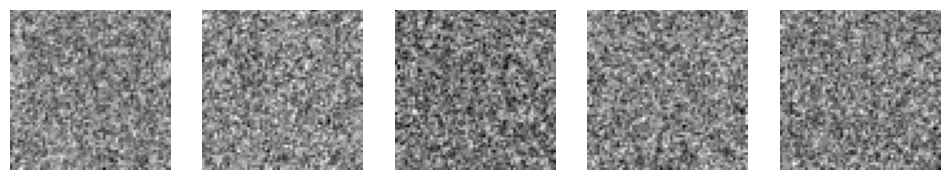

In [10]:
## Loading and Preprocessing Microstructure Data

# For this example, we'll use a dataset of grayscale microstructure images.
# You can replace this with your own dataset.

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Load dataset (Replace with your dataset path)
dataset = datasets.FakeData(transform=transform)  # Using FakeData as placeholder
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Display a few sample images
def show_samples(loader):
    images, _ = next(iter(loader))
    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    for i in range(5):
        axes[i].imshow(images[i].squeeze(), cmap='gray')
        axes[i].axis('off')
    plt.show()

show_samples(dataloader)


We can also load our own images from a folder in google drive

Mounted at /content/drive


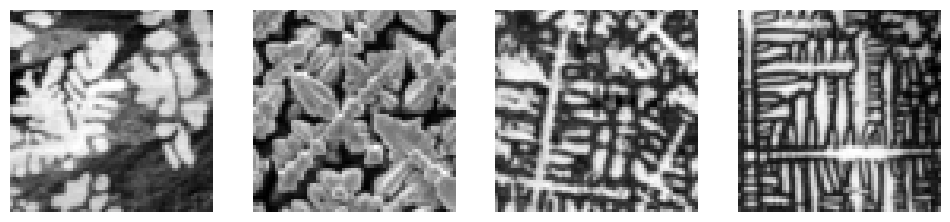

In [11]:
## Loading and Preprocessing Microstructure Data from Google Drive

from google.colab import drive
from torchvision.io import read_image
import os
from PIL import Image

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define the path to your image folder in Google Drive
image_folder = "/content/drive/My Drive/teaching/5540-6640 Materials Informatics/MaterialsInformatics/worked_examples/diffusion_dendrites/images"  # Change this to your folder path

# Step 3: Define transformation pipeline with resizing and center cropping
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize(80),  # Resize the shorter side to 80 while maintaining aspect ratio
    transforms.CenterCrop((64, 64)),  # Crop the center to 64x64
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])


# Step 4: Load images from folder
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("L")  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image, 0  # No labels needed, returning 0 as a placeholder

# Create dataset and dataloader
dataset = CustomImageDataset(image_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Display a few sample images
def show_samples(loader):
    images, _ = next(iter(loader))
    fig, axes = plt.subplots(1, min(len(images), 5), figsize=(12, 3))
    for i in range(min(len(images), 5)):
        axes[i].imshow(images[i].squeeze(), cmap='gray')
        axes[i].axis('off')
    plt.show()

show_samples(dataloader)


In [12]:
## Defining a Simple Diffusion Model

# We define a UNet-like model commonly used in diffusion models.
# This model will learn to remove noise step-by-step from an input image.

class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh()  # Output in range [-1,1] (similar to normalized input)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize model and move to device
model = SimpleUNet().to(device)
print(model)


SimpleUNet(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Tanh()
  )
)


In [13]:
## Training the Diffusion Model

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (simplified)
num_epochs = 5

for epoch in range(num_epochs):
    for images, _ in dataloader:
        images = images.to(device)

        # Add noise to images (forward process)
        noise = torch.randn_like(images).to(device)
        noisy_images = images + 0.2 * noise  # Controlled noise addition

        # Model tries to predict the original image
        optimizer.zero_grad()
        outputs = model(noisy_images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("Training complete!")


Epoch [1/5], Loss: 0.1365
Epoch [2/5], Loss: 0.0384
Epoch [3/5], Loss: 0.0885
Epoch [4/5], Loss: 0.0442
Epoch [5/5], Loss: 0.0530
Training complete!


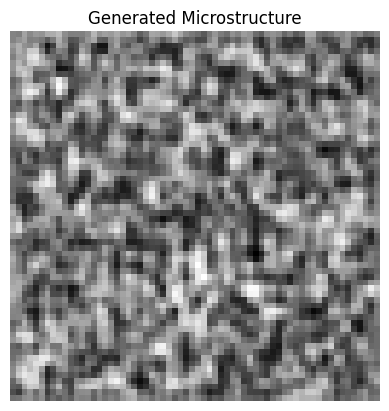

In [14]:
## Generating New Microstructures

# Start with random noise and apply the trained model to denoise

def generate_microstructure(model, device):
    model.eval()
    with torch.no_grad():
        noise = torch.randn(1, 1, 64, 64).to(device)  # Random noise input
        generated_image = model(noise).cpu().squeeze()

    plt.imshow(generated_image, cmap='gray')
    plt.axis('off')
    plt.title("Generated Microstructure")
    plt.show()

generate_microstructure(model, device)
